<a href="https://colab.research.google.com/github/samlim1104/PneumoniaDetectionApp/blob/main/Section3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Setup & Data Preparation Cell { display-mode: "form" }

# -------------------------- #
# INSTALLATION
# -------------------------- #
!pip install -q albumentations

# -------------------------- #
# IMPORTS
# -------------------------- #
import os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import (Activation, MaxPooling2D, Dropout, Flatten, Reshape,
                          Dense, Conv2D, GlobalAveragePooling2D, Input)
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG16, VGG19, DenseNet121
from tensorflow.keras.applications import ResNet50

import albumentations as A

# -------------------------- #
# AUGMENTATION FUNCTIONS
# -------------------------- #
def apply_aug(data, transform):
    if len(data.shape) == 3:
        return transform(image=data)['image']
    return np.stack([transform(image=img)['image'] for img in data])

def rotate(data, angle):
    return apply_aug(data, A.Rotate(limit=angle, p=1))

def shear(data, shear_val):
    return apply_aug(data, A.Affine(shear={"x": shear_val, "y": 0}, p=1))

def scale(data, scale_val):
    return apply_aug(data, A.Affine(scale=scale_val, p=1))

def flip_left_right(data, prob): return apply_aug(data, A.HorizontalFlip(p=prob))
def flip_up_down(data, prob): return apply_aug(data, A.VerticalFlip(p=prob))

def remove_color(data, channel):
    new_data = data.copy()
    if len(data.shape) == 3:
        new_data[:, :, channel] = 0
    elif len(data.shape) == 4:
        new_data[:, :, :, channel] = 0
    return new_data

# -------------------------- #
# DATA LOADING & PROCESSING
# -------------------------- #
class pkg:
    @staticmethod
    def get_metadata(metadata_path, splits=['train', 'test']):
        return pd.read_csv(metadata_path).query("split in @splits")

    @staticmethod
    def get_data_split(split_name, flatten, all_data, metadata, shape):
        df = metadata[metadata['split'] == split_name]
        data = all_data[df['index'].values]
        labels = df['class'].values
        return data.reshape([-1, np.prod(shape)]) if flatten else data, labels

    @staticmethod
    def get_field_data(flatten, all_data, metadata, shape):
        data, labels = pkg.get_data_split('field', flatten, all_data, metadata, shape)
        data[:, :, :, 1] = data[:, :, :, 0]
        data[:, :, :, 2] = data[:, :, :, 0]
        rand = random.uniform(-1, 1)
        for i in range(len(data)):
            data[i] = rotate(data[i], rand * 40) if abs(rand) < 0.5 else shear(data[i], rand * 40)
        return data, labels

# -------------------------- #
# HELPER FUNCTIONS
# -------------------------- #
class helpers:
    @staticmethod
    def plot_one_image(data, labels=[], index=None, shape=[64, 64, 3]):
        if data.ndim == 1:
            data = data.reshape(shape)
        elif data.ndim == 2:
            data = data.reshape([-1] + shape)

        img = data if data.ndim == 3 else data[index]
        label = labels if data.ndim == 3 else labels[index]
        print(f"Label: {label}")
        plt.imshow(img)
        plt.show()

    @staticmethod
    def plot_acc(history, ax=None, xlabel='Epoch #'):
        history = pd.DataFrame(history.history)
        history['epoch'] = history.index
        best_epoch = history['val_accuracy'].idxmax()

        if ax is None:
            _, ax = plt.subplots()
        sns.lineplot(data=history, x='epoch', y='accuracy', label='Training', ax=ax)
        sns.lineplot(data=history, x='epoch', y='val_accuracy', label='Validation', ax=ax)
        ax.axhline(0.5, ls='--', color='red', label='Chance')
        ax.axvline(best_epoch, ls='--', color='green', label='Best Epoch')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Accuracy')
        ax.legend()
        plt.show()

    @staticmethod
    def combine_data(data_list, label_list):
        return np.concatenate(data_list, axis=0), np.concatenate(label_list, axis=0)

# -------------------------- #
# MODEL BUILDERS
# -------------------------- #
class models:
    @staticmethod
    def DenseClassifier(hidden_layers, params):
        model = Sequential([Input(params['input_shape']), Flatten(), Dropout(0.5)])
        for size in hidden_layers:
            model.add(Dense(size, activation='relu'))
            model.add(Dropout(0.5))
        model.add(Dense(params['output_neurons'], activation=params['output_activation']))
        model.compile(loss=params['loss'],
                      optimizer=keras.optimizers.SGD(1e-4, momentum=0.95),
                      metrics=['accuracy'])
        return model

    @staticmethod
    def CNNClassifier(n_layers, params):
        model = Sequential([Input(params['input_shape']),
                            Conv2D(32, 3, padding='same', kernel_regularizer=l2(0.01)), Activation('relu'),
                            MaxPooling2D(2)])
        for _ in range(n_layers - 1):
            model.add(Conv2D(64, 3, padding='same', kernel_regularizer=l2(0.01)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.5))
        model.add(Dense(params['output_neurons'], activation=params['output_activation']))
        model.compile(loss=params['loss'],
                      optimizer=keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9),
                      metrics=['accuracy'])
        return model

    @staticmethod
    def TransferClassifier(name, params, trainable=False):
        base_model = {'VGG16': VGG16, 'VGG19': VGG19,
                      'ResNet50': ResNet50, 'DenseNet121': DenseNet121}[name](
            include_top=False, weights='imagenet', input_shape=params['input_shape']
        )
        for layer in base_model.layers:
            layer.trainable = trainable
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(params['output_neurons'], activation=params['output_activation'])
        ])
        model.compile(loss=params['loss'],
                      optimizer=keras.optimizers.SGD(1e-4, momentum=0.9),
                      metrics=['accuracy'])
        return model

# -------------------------- #
# CONFIGURATION
# -------------------------- #
image_shape = (64, 64, 3)
metadata_path = './metadata.csv'
image_data_path = './image_data.npy'
metadata_url = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_url = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'

!wget -q --show-progress "$metadata_url" -O $metadata_path
!wget -q --show-progress "$image_url" -O $image_data_path

_all_data = np.load(image_data_path)
_metadata = pkg.get_metadata(metadata_path, ['train', 'test', 'field'])

# -------------------------- #
# SHORTCUTS
# -------------------------- #
get_metadata = lambda: pkg.get_metadata(metadata_path, ['train', 'test'])
get_train_data = lambda flatten=False: pkg.get_data_split('train', flatten, _all_data, _metadata, image_shape)
get_test_data = lambda flatten=False: pkg.get_data_split('test', flatten, _all_data, _metadata, image_shape)
get_field_data = lambda flatten=False: pkg.get_field_data(flatten, _all_data, _metadata, image_shape)

plot_one_image = lambda data, labels=[], index=None: helpers.plot_one_image(data, labels, index, image_shape)
plot_acc = helpers.plot_acc
combine_data = helpers.combine_data

DenseClassifier = lambda h: models.DenseClassifier(h, nn_params)
CNNClassifier = lambda n: models.CNNClassifier(n, nn_params)
TransferClassifier = lambda name: models.TransferClassifier(name, nn_params)

monitor = ModelCheckpoint('./model.keras', monitor='val_accuracy', save_best_only=True)

# -------------------------- #
# MODEL PARAMS
# -------------------------- #
nn_params = {
    'input_shape': image_shape,
    'output_neurons': 1,
    'loss': 'binary_crossentropy',
    'output_activation': 'sigmoid'
}

./metadata.csv      100%[===================>]  39.56K  --.-KB/s    in 0.04s   
./image_data.npy    100%[===================>] 131.25M  23.1MB/s    in 6.9s    


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.4858 - loss: 1.9883 - val_accuracy: 0.5375 - val_loss: 1.7471
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6250 - loss: 1.6586 - val_accuracy: 0.6325 - val_loss: 1.4462
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8082 - loss: 1.2235 - val_accuracy: 0.7625 - val_loss: 1.1332
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9038 - loss: 0.9096 - val_accuracy: 0.6975 - val_loss: 1.3278
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9080 - loss: 0.7372 - val_accuracy: 0.6450 - val_loss: 1.2140
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9309 - loss: 0.6044 - val_accuracy: 0.7150 - val_loss: 1.1860
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9499 - loss: 0.4774 - val_accuracy: 0.6450 - val_loss: 1.1775
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9326 - loss: 0.4534 - val_accuracy: 0.6800 - val_loss

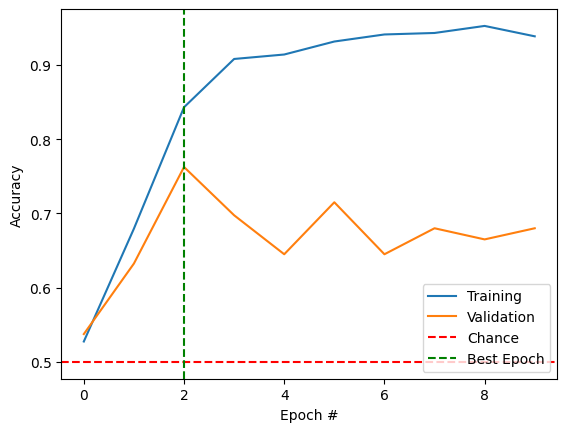

In [2]:
X_train, y_train = get_train_data()
X_test, y_test   = get_test_data()

### YOUR CODE HERE
cnn = CNNClassifier(2)
cnn_history = cnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=True, callbacks=[monitor])
plot_acc(cnn_history)

### END CODE

In [4]:
### YOUR CODE HERE
X_field, y_field = get_field_data()

y_pred = (cnn.predict(X_field) > 0.5)
accuracy_score(y_field, y_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


0.645

What accuracy do you get when you use your trained CNN on the field data? Please calculate it below!

Hint: if your predictions are saved as `pred_probabilities`, what do you think something like `pred_probabilities > 0.5` would do? Test it out!

## Instructor Solution
<details><summary>click to reveal!</summary>

**Discuss: How does your performance on field data compare to test and train data?**

- **Training Data**: Typically, the model shows the highest accuracy on the training data since it has been directly trained on this data. High accuracy on training data indicates that the model has learned the patterns present in the training set well.
- **Test Data**: This dataset is used to evaluate the model's performance on unseen data, providing a more realistic estimate of how the model will perform in real-world scenarios. Performance on test data is usually slightly lower than on training data due to the model's limited exposure to these data points.
- **Field Data**: Performance on field data often varies the most. This data represents real-world conditions, which can include a lot more variability and noise compared to the controlled training and test datasets. As a result, performance on field data can be lower than on both training and test data.

You've probably noticed that you get different performance every time you train your model! Let's get a sense of the average: below, please **train your model 5 times, calculate the accuracy on the field data each time, and print the average accuracy.**

In [5]:
### YOUR CODE HERE
number_of_runs = 5
accuracy_total = 0

for i in range(number_of_runs):
  cnn_temp = CNNClassifier(5)
  cnn_temp.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), shuffle=True, callbacks=[monitor])

  y_pred = (cnn_temp.predict(X_field) > 0.5)

  accuracy = accuracy_score(y_field, y_pred)
  print('Accuracy on this run:', accuracy)
  accuracy_total += accuracy

print('Average accuracy:', accuracy_total / number_of_runs)
### END CODE

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.4934 - loss: 3.8219 - val_accuracy: 0.5000 - val_loss: 3.3045
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5183 - loss: 3.1489 - val_accuracy: 0.5800 - val_loss: 2.7093
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5524 - loss: 2.5897 - val_accuracy: 0.7550 - val_loss: 2.2490
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5911 - loss: 2.1565 - val_accuracy: 0.7875 - val_loss: 1.8823
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6097 - loss: 1.8185 - val_accuracy: 0.7725 - val_loss: 1.6023
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Accuracy on this run: 0.6975
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.5137 - loss: 3.8109 - val_accuracy: 0.6975 - val_loss: 3.2955
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5666 - loss: 3.1385 - val_accuracy: 0.5000 - val_loss: 2.7104
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step -

## Instructor Solution
<details><summary>click to reveal!</summary>

**Hypotheses for Differences Between Test Data and Field Data**
   - Field data likely contains more noise and irrelevant information due to real-world variability and less controlled collection environments, whereas test data is typically cleaner and more curated, with noise and irrelevant data minimized during preprocessing.
   - Field data contains more edge cases and unusual instances that the model might not have encountered during training.

Since our `X_field` comes from the field, it's possible that it's different from `X_train` and `X_test` in some important ways!

Let's compare a few images. Below, please use a `for` loop and `plot_one_image(data, labels, index)` to print out a few images from the different datasets.

**Do you notice any differences in the datasets?**




FIELD data:
Label: 1.0


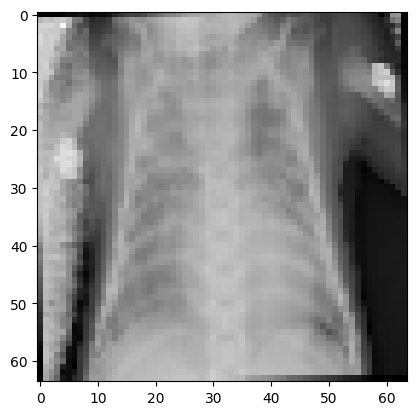

Label: 1.0


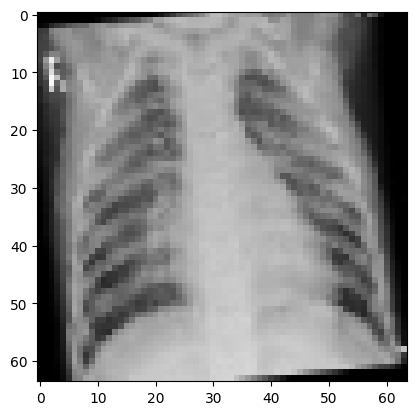

Label: 0.0


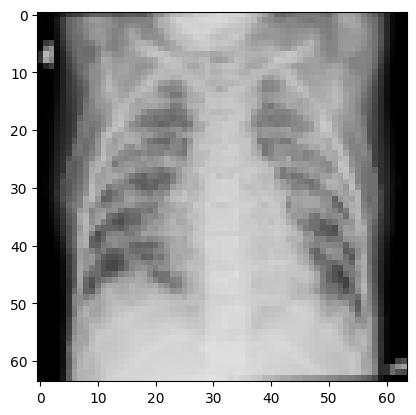

Label: 0.0


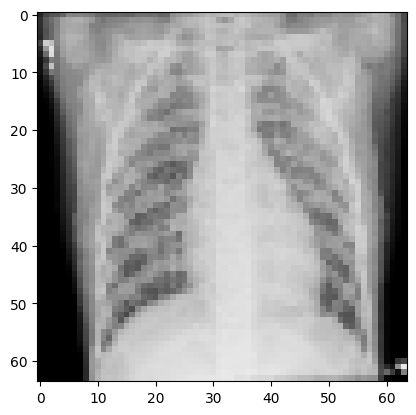

Label: 0.0


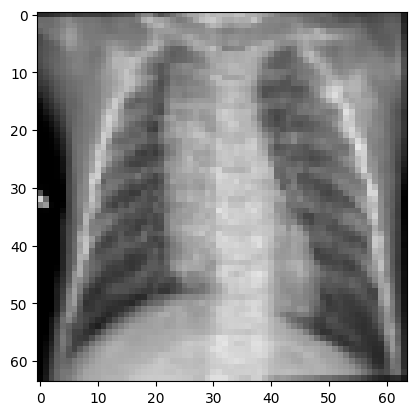

Label: 1.0


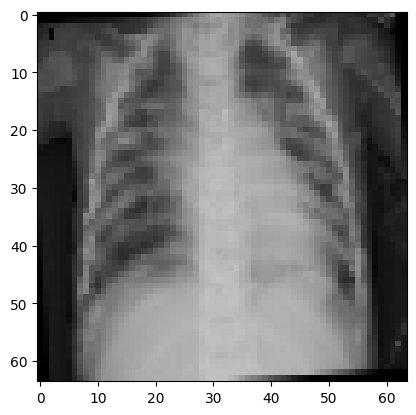

Label: 0.0


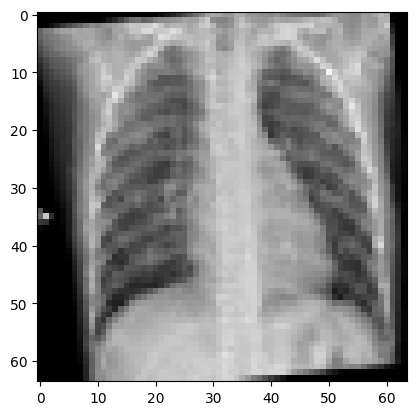

Label: 1.0


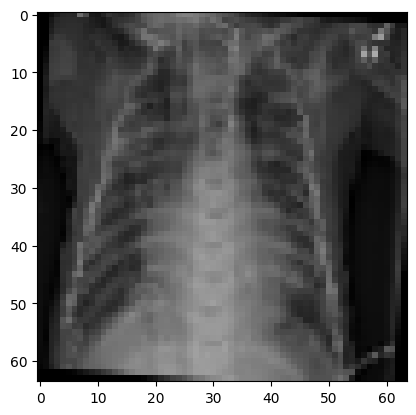

Label: 0.0


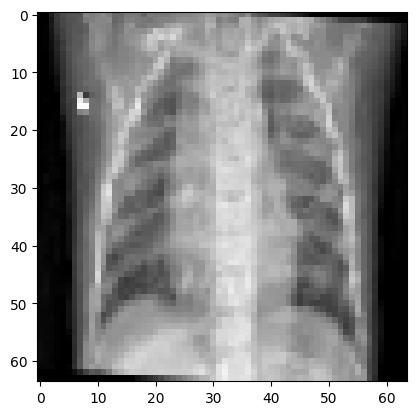

Label: 0.0


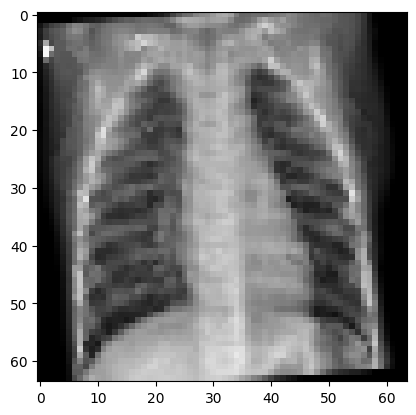

TRAIN data:
Label: 0.0


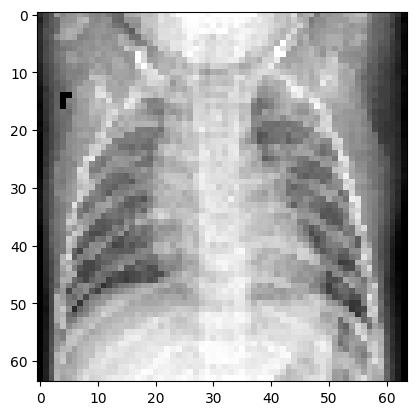

Label: 0.0


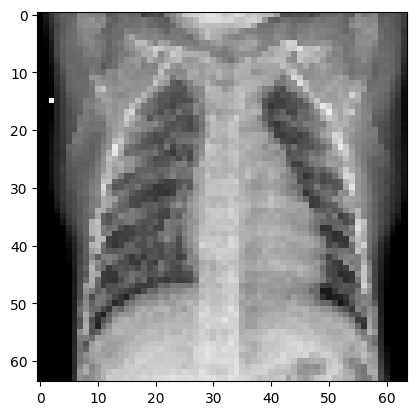

Label: 1.0


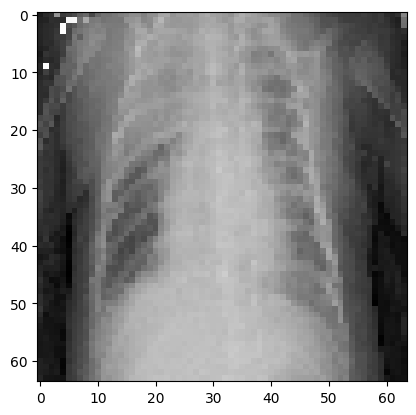

Label: 0.0


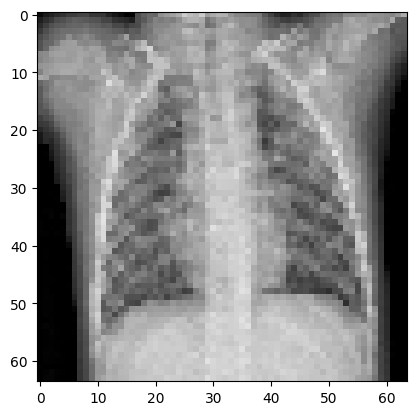

Label: 1.0


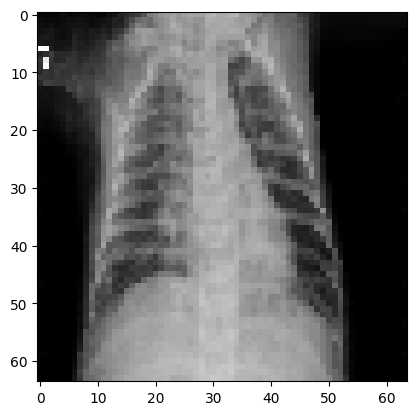

Label: 1.0


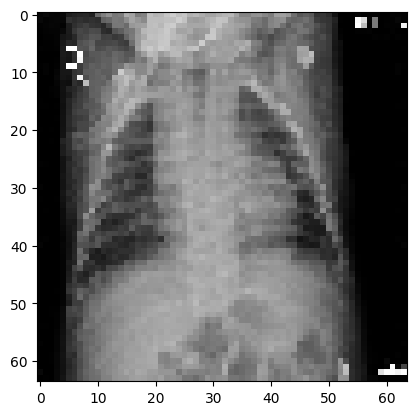

Label: 1.0


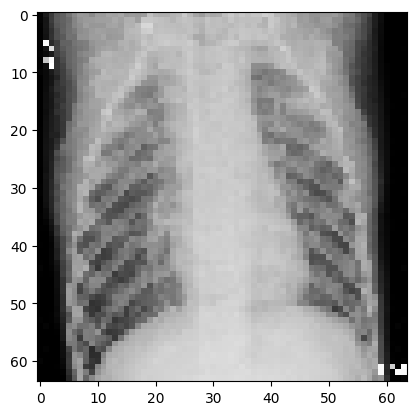

Label: 0.0


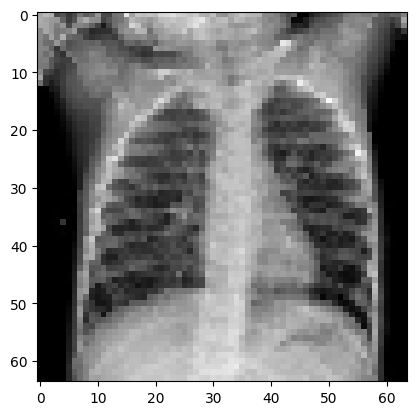

Label: 1.0


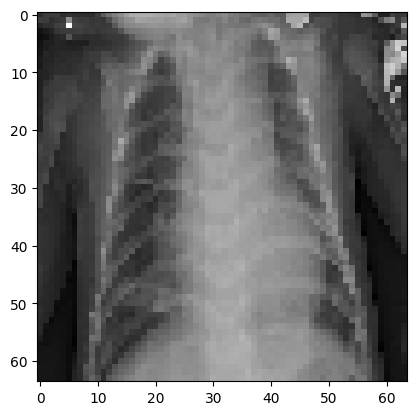

Label: 1.0


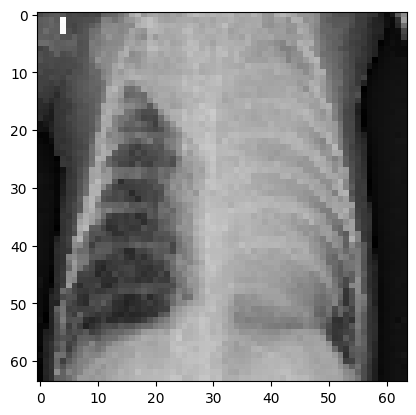

TEST data:
Label: 1.0


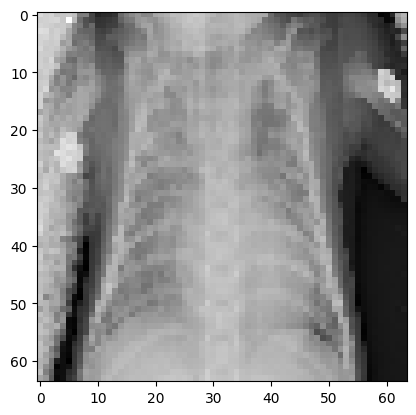

Label: 1.0


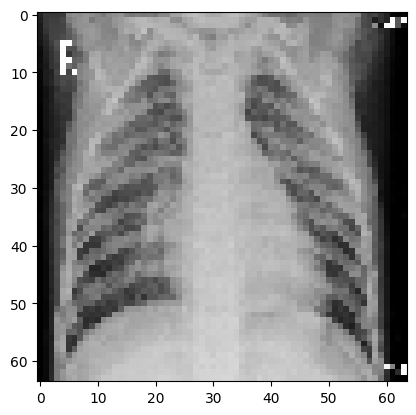

Label: 0.0


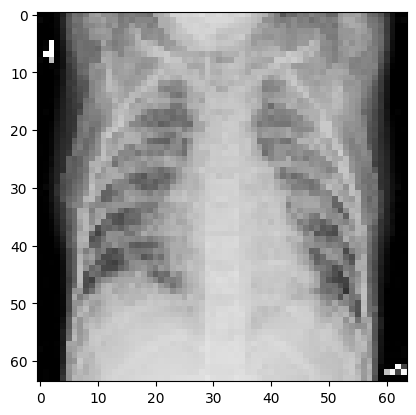

Label: 0.0


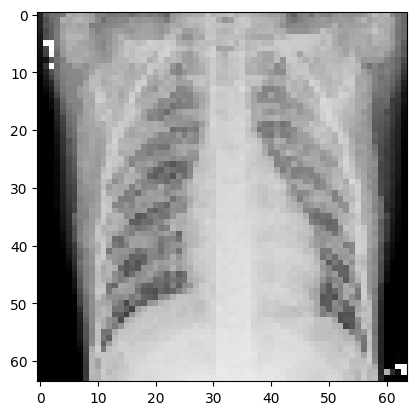

Label: 0.0


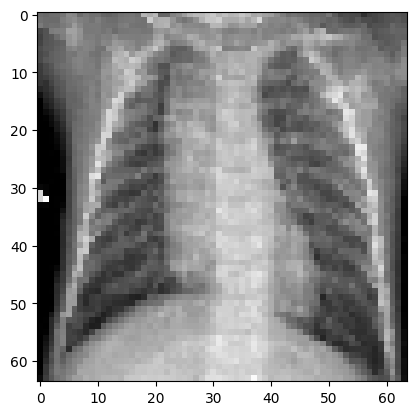

Label: 1.0


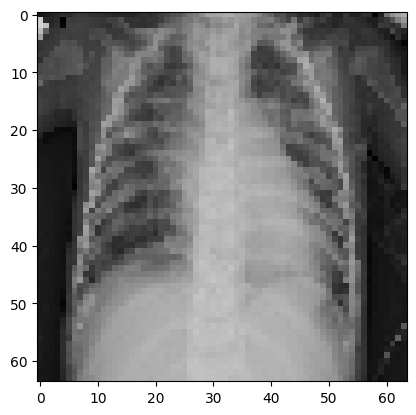

Label: 0.0


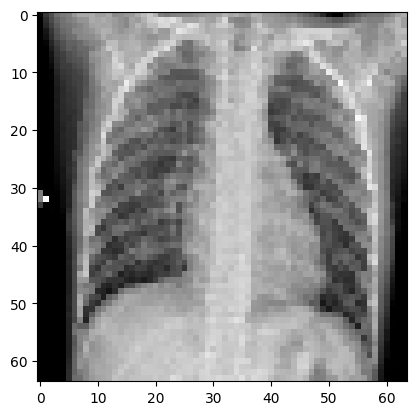

Label: 1.0


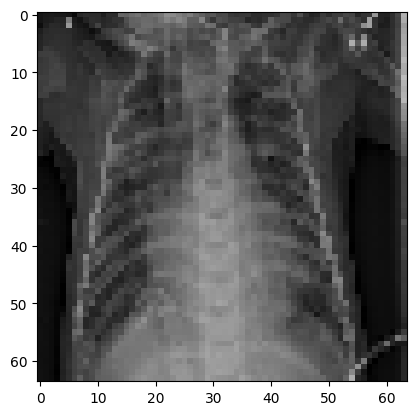

Label: 0.0


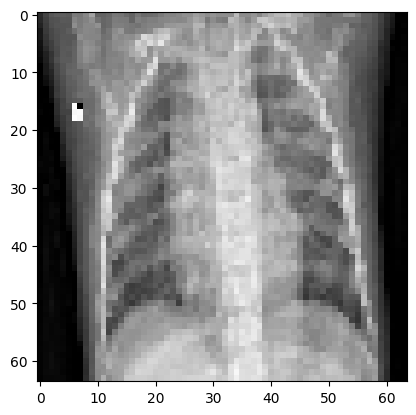

Label: 0.0


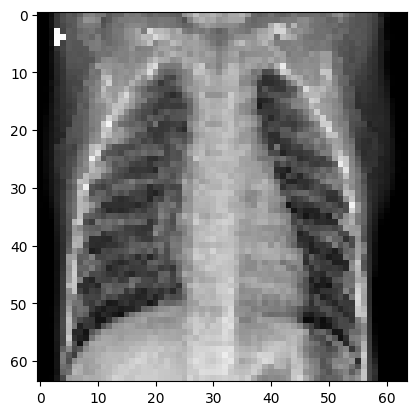

In [6]:
### YOUR CODE HERE
print ("FIELD data:")
for i in range(10):
  plot_one_image(X_field, y_field, i)

print ("TRAIN data:")
for i in range(10):
  plot_one_image(X_train, y_train, i)

print ("TEST data:")
for i in range(10):
  plot_one_image(X_test, y_test, i)
### END CODE

## Instructor-Led Discussion: What is happening in our field data?

Discuss in your group and with your instructor:

Why is our model performance suffering? What are reasons that field data could be "messier"?

## Instructor Solution
<details><summary>click to reveal!</summary>

Field data often comes with a lot more variability than controlled datasets. Variations can include changes in lighting, background, or context that were not present in the training data. In addition, Field data might have missing values or incomplete records, making it harder for the model to make accurate predictions.

### Instructor-Led Discussion: Data Augmentation

We want our model to handle a broader variety of input data. One way to do this is to **augment** our data: by intentionally making some alterations to our input data, we can train our model to handle a greater variety of outputs.

So, how do we augment our images in Python?


We provide custom functions for augmenting a single image. Here's one example, to rotate a single image by 40 degrees. **Experiment with changing the degrees! How can you rotate left?**

Label: []


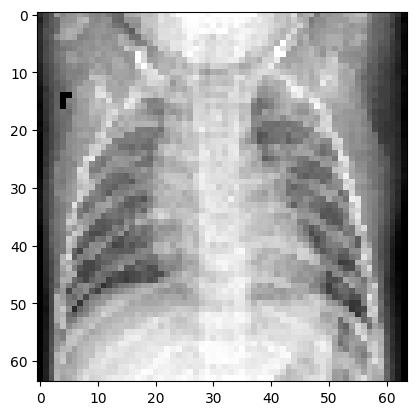

Label: []


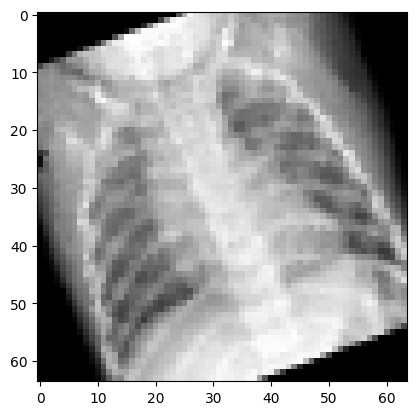

In [7]:
image = X_train[0]
plot_one_image(image)
new_image = rotate(image, 40)
plot_one_image(new_image)


Here's some more image transformation options:
* `rotate(image, 30)`
* `scale(image, 1.5)`
* `shear(image, 20)`
* `flip_left_right(image, prob = 0.5)`
* `flip_up_down(image, prob = 0.5)`
* `remove_color(image, channel = 0)`

Try it out below!

Label: []


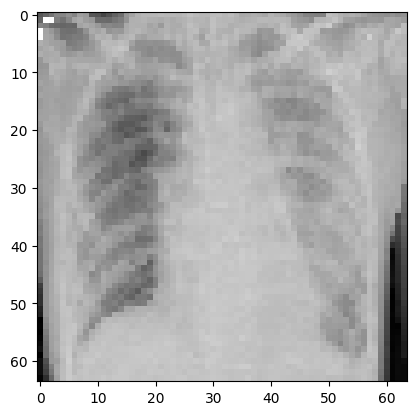

Label: []


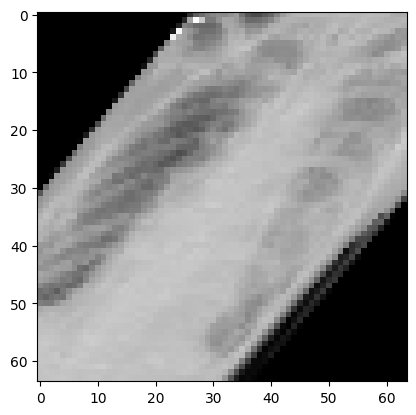

In [8]:
### YOUR CODE HERE
image = X_train[30]
plot_one_image(image)
new_image = shear(image, 40)
plot_one_image(new_image)

Now, let's create some augmented datasets of our own! We'll combine the augmented data with the original. Here's how you make an augmented dataset with a custom function we've defined for you:

In [9]:
train_data_rotated_10 = rotate(X_train, 10)

Please make some more augmented datasets below!

In [10]:
### YOUR CODE HERE to create more augmented datasets
train_data_rotated_10 = rotate(X_train, 10)
train_data_rotated_180 = rotate(X_train, 180)
train_data_rotated_270 = rotate(X_train, 270)
red_train = remove_color(remove_color(X_train, channel = 1), channel = 2)



Finally, to combine your original train data with your augmented data, you can use the `combine_data` function like this:
```
all_data, all_labels = combine_data([data1, data2], [labels1, labels2])
```

(You can include as many datasets as you like in the list. What should you use for the new labels?)

Please create `all_data` and `all_labels` below:

In [11]:
### YOUR CODE HERE
all_data, all_labels = combine_data([X_train, train_data_rotated_10, train_data_rotated_180, train_data_rotated_270, red_train], \
                                    [y_train, y_train, y_train, y_train, y_train,])
### END CODE

Once you've created your augmented data...
1. Train your CNN on `all_data`
2. Choose the best epoch based on the `X_test`
3. Load your model up and score it on `X_field`

**Your challenge is to find a set of augmentations that improves your model's performance on the `X_field`! Share your augmentations and performances with the class! Try as many or as few augmentations as you want.**

**Remember to record an average of 5 newly initialized CNNs. This is important because CNN weights will be initialized differently in each run!**

In [12]:
X_train, y_train = get_train_data()
X_test, y_test   = get_test_data()
X_field, y_field   = get_field_data()

### YOUR CODE HERE
for i in range(5):
  cnn = CNNClassifier(2)
  cnn.fit(all_data, all_labels, epochs=5, validation_data=(X_test, y_test), shuffle=True, callbacks=[monitor])
  predictions = (cnn.predict(X_field) > 0.5)

  accuracy = accuracy_score(y_field, predictions)
  print('Accuracy:', accuracy)
  accuracy_total += accuracy

average_accuracy = accuracy_total / number_of_runs

print('Average accuracy: ', average_accuracy)
### END CODE

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5582 - loss: 1.7109 - val_accuracy: 0.8250 - val_loss: 0.8005
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8394 - loss: 0.7056 - val_accuracy: 0.7650 - val_loss: 0.6522
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8867 - loss: 0.4138 - val_accuracy: 0.7525 - val_loss: 0.7341
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9044 - loss: 0.3097 - val_accuracy: 0.7850 - val_loss: 0.5284
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9113 - loss: 0.2948 - val_accuracy: 0.8250 - val_loss: 0.4680
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Accuracy: 0.8125
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5666 - loss: 1.6976 - val_accuracy: 0.7700 - val_loss: 0.8902
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8641 - loss: 0.6703 - val_accuracy: 0.7700 - val_loss: 0.6526
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step -

## Saving Your Model for a Web App

Now that you've finished up with training your models on augmented data, you can use the cell below to save the model for use with a web app in the next notebook!

This cell saves whatever is in the `cnn` variable, so if your model is in a different variable, change `cnn.save(file_name)` to `YOUR_MODEL.save(file_name)` in the code cell!


In [14]:
#@title Run this cell to download your model to use in the next notebook's app deployment!
import shutil
from google.colab import drive, files

#@markdown > You're free to change the name of the saved file below; just make sure it ends in `.keras`!
#@markdown - If you're saving multiple different models, you'll definitely want to change the file name between saves. Make sure the name is descriptive so you remember which file is which!
file_name = "cnn_model_pneumonia_detection.keras" #@param {"type":"string"}
cnn.save(file_name)

#@markdown ---
#@markdown > If you want the file saved to your Google Drive, keep the box checked! Once you run the cell, it will ask for access. If you don't have enough space, you can uncheck the box to download the file to your computer.
download_to_Google_Drive = True  # @param {"type":"boolean"}

# Copy to Google Drive or download it
if download_to_Google_Drive:
    drive.mount('/content/drive')
    shutil.copy(file_name, '/content/drive/My Drive/')
else:
    files.download(file_name)



Mounted at /content/drive
